In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
EPOCHS = 150
EPOCH_PATIENCE = 11

BATCH_SIZE = 64
NUM_CLASSES = 102

LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.00001

L1_NORM = 0.0001
ROOT = "/Users/maciek/cnn_data"

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
class FavConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(FavConvolutionalNetwork, self).__init__()
        self.fc1 = nn.Linear(224*224*3, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.drop = nn.Dropout(p=0.7)
        self.out = nn.Linear(1024, NUM_CLASSES)

    
    def forward(self, x):
        #print(x.shape)
        x = x.view(-1, 224*224*3)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        
        x = self.out(x)

        return x

In [4]:
# mean and std of the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_data = datasets.Flowers102(root=ROOT, split = 'train', download=True, transform=transform)
train_load = DataLoader(train_data, batch_size = 10, shuffle = False)

# this function gives the approximate mean and std of the dataset
def mean_std(loader):
  mean = 0
  std = 0
  image_count = 0

  for images, _ in loader:
    image_count_batch = images.size(0)
    images = images.view(image_count_batch, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    image_count += image_count_batch

  mean /= image_count
  std /= image_count

  return mean, std

mean, std = mean_std(train_load)
print(mean, std)

tensor([0.4330, 0.3819, 0.2964]) tensor([0.2587, 0.2093, 0.2210])


In [5]:
train_transform_1 = Compose([
    Resize((224,224)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomRotation(30),
    ToTensor(),
    Normalize(mean, std)
])
train_transform_2 = Compose([
    Resize((224, 224)),
    ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    RandomPerspective(distortion_scale=0.4, p=0.6),
    ToTensor(),
    Normalize(mean, std)
])

test_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean, std)
])

In [6]:
train_data_1 = datasets.Flowers102(root=ROOT, split='train', download=True, transform=test_transform)
train_data_2 = datasets.Flowers102(root=ROOT, split='train', download=True, transform=train_transform_1)
train_data_3 = datasets.Flowers102(root=ROOT, split='train', download=True, transform=train_transform_2)
train_data = train_data_1

val_data = datasets.Flowers102(root=ROOT, split='val', download=True, transform=test_transform)
test_data = datasets.Flowers102(root=ROOT, split='test', download=True, transform=test_transform)

In [7]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
model = FavConvolutionalNetwork().to(DEVICE)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5)

In [9]:
def l1_norm(model):
    l1_regularization = torch.tensor(0.).to(DEVICE)
    for param in model.parameters():
        l1_regularization += torch.norm(param, 1)
    return l1_regularization    

In [10]:
import time

start_time = time.time()

# Create Variables To Tracks Things
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Early Stopping Parameters
patience = EPOCH_PATIENCE  # How many epochs to wait after val loss has stopped improving
min_val_loss = float('inf')
stale_epochs = 0  # Counter for epochs without improvement

for i in range(EPOCHS):
    trn_corr = 0
    tst_corr = 0

    # Update the train_loader with the new transformations
    # current_transform = update_transform(i)  # Get the updated transform for the current epoch
    # train_data.transform = current_transform  # Update the transform in the dataset
    # train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)  # Recreate the DataLoader with the updated dataset

    # Train
    model.train()
    running_loss = 0
    for b, (X_train, y_train) in enumerate(train_loader, 1):
        X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
        y_pred = model(X_train)  # get predicted values from the training set. Not flattened 2D
        loss = criterion(y_pred, y_train)  # how off are we? Compare the predictions to correct answers in y_train

        predicted = torch.max(y_pred.data, 1)[
            1]  # add up the number of correct predictions. Indexed off the first point
        batch_corr = (predicted == y_train).sum()  # how many we got correct from this batch. True = 1, False=0, sum those up
        trn_corr += batch_corr  # keep track as we go along in training.

        l1_loss = L1_NORM * l1_norm(model)
        total_loss = l1_loss + loss
        running_loss += total_loss.item() * X_train.size(0)
        # Update our parameters
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Print out some results
        #if b % BATCH_SIZE == 0:
            #print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_correct.append(trn_corr)

    # Test
    model.eval()
    total = 0
    with torch.no_grad():
        val_loss = 0
        for b, (X_test, y_test) in enumerate(val_loader):
            X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            total += y_test.size(0)
            val_loss += criterion(y_val, y_test).item()  # Sum up the loss from each batch

    avg_val_loss = val_loss / len(val_loader)  # Calculate the average loss

    test_losses.append(avg_val_loss)
    test_correct.append(tst_corr)

    scheduler.step(avg_val_loss)

    # Early Stopping Check
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        stale_epochs = 0  # Reset the stale epochs counter
        best_model_state = model.state_dict()
    else:
        stale_epochs += 1  # Increment the stale epochs counter
        if stale_epochs >= patience:
            print(f'Stopping early at epoch {i} due to overfitting.')
            model.load_state_dict(best_model_state)
            break  # Break out of the loop

    print(f'[{i}/{EPOCHS}] train_loss: {avg_train_loss:.3f} val_loss: {avg_val_loss:.3f} val_acc: {(tst_corr/total)*100:.1f}%')

current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total / 60} minutes!')


[0/150] train_loss: 3289.878 val_loss: 4.588 val_acc: 3.5%
[1/150] train_loss: 3128.963 val_loss: 4.491 val_acc: 6.4%
[2/150] train_loss: 2882.819 val_loss: 4.392 val_acc: 6.8%
[3/150] train_loss: 2685.374 val_loss: 4.353 val_acc: 7.8%
[4/150] train_loss: 2506.854 val_loss: 4.354 val_acc: 6.8%
[5/150] train_loss: 2335.646 val_loss: 4.309 val_acc: 7.8%
[6/150] train_loss: 2174.249 val_loss: 4.268 val_acc: 7.9%
[7/150] train_loss: 2024.158 val_loss: 4.264 val_acc: 8.7%
[8/150] train_loss: 1886.739 val_loss: 4.273 val_acc: 8.6%
[9/150] train_loss: 1761.456 val_loss: 4.267 val_acc: 8.3%
[10/150] train_loss: 1650.719 val_loss: 4.256 val_acc: 9.3%
[11/150] train_loss: 1542.820 val_loss: 4.258 val_acc: 9.0%
[12/150] train_loss: 1454.503 val_loss: 4.259 val_acc: 8.1%
[13/150] train_loss: 1381.908 val_loss: 4.252 val_acc: 8.2%
[14/150] train_loss: 1322.449 val_loss: 4.279 val_acc: 8.1%
[15/150] train_loss: 1271.124 val_loss: 4.270 val_acc: 8.4%
[16/150] train_loss: 1219.538 val_loss: 4.267 val_

KeyboardInterrupt: 

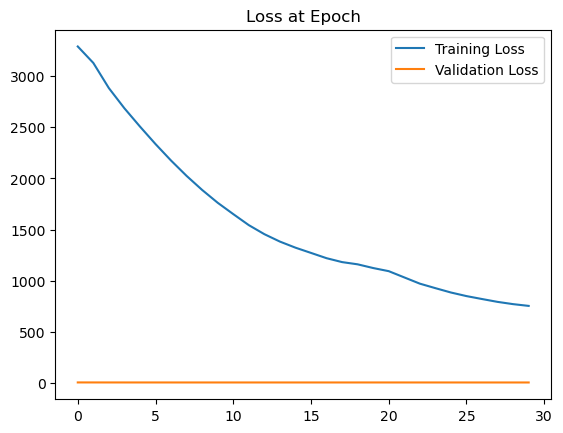

In [11]:
# Convert GPU tensors to CPU tensors, detach them from the computation graph, and then to NumPy arrays
train_losses = [tl for tl in train_losses]
test_losses = [tl for tl in test_losses]

# Now you can plot using matplotlib
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()
plt.show(block=True)

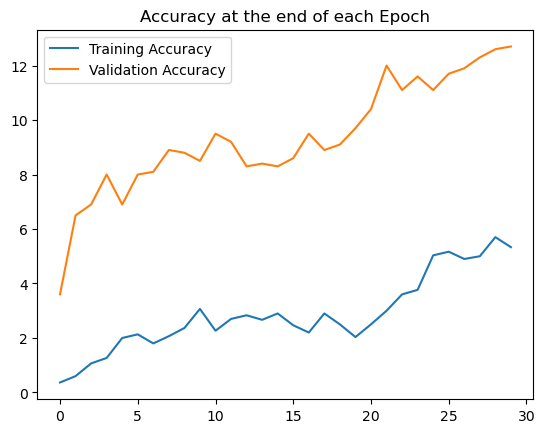

In [12]:
plt.plot([t.cpu()/30 for t in train_correct], label="Training Accuracy")
plt.plot([t.cpu()/10 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
# Load the best model state
test_load_everything = DataLoader(test_data, batch_size=512, shuffle=False)

# Initialize lists to store predictions and true labels for evaluation
final_predictions = []
final_true_labels = []

# Evaluation loop
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for X_test, y_test in test_load_everything:
        X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test).sum().item()
        total += y_test.size(0)
        
        # Store predictions and true labels
        final_predictions.extend(predicted.view(-1).cpu().numpy())
        final_true_labels.extend(y_test.view(-1).cpu().numpy())

# Convert lists to numpy arrays
predictions = np.array(final_predictions)
true_labels = np.array(final_true_labels)

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)
accuracy = correct / total

print(f'Accuracy of the model on the test set: {accuracy * 100:.2f}%')
print(f"Final Precision: {precision}")
print(f"Final Recall: {recall}")
print(f"Final F1 Score: {f1}")

Accuracy of the model on the test set: 10.41%
Final Precision: 0.11245002134480762
Final Recall: 0.10408196454708082
Final F1 Score: 0.07259395399992914


/opt/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
